Index(['country', 'location_name', 'latitude', 'longitude', 'timezone',
       'last_updated_epoch', 'last_updated', 'temperature_celsius',
       'temperature_fahrenheit', 'condition_text', 'wind_mph', 'wind_kph',
       'wind_degree', 'wind_direction', 'pressure_mb', 'pressure_in',
       'precip_mm', 'precip_in', 'humidity', 'cloud', 'feels_like_celsius',
       'feels_like_fahrenheit', 'visibility_km', 'visibility_miles',
       'uv_index', 'gust_mph', 'gust_kph', 'air_quality_Carbon_Monoxide',
       'air_quality_Ozone', 'air_quality_Nitrogen_dioxide',
       'air_quality_Sulphur_dioxide', 'air_quality_PM2.5', 'air_quality_PM10',
       'air_quality_us-epa-index', 'air_quality_gb-defra-index', 'sunrise',
       'sunset', 'moonrise', 'moonset', 'moon_phase', 'moon_illumination'],
      dtype='object')
Column 'lastupdated' does not exist. Please check the column name.


<ipython-input-10-3247d971f8ab>:48: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data['temperature_celsius'] = weather_data['temperature_celsius'].fillna(method='ffill')


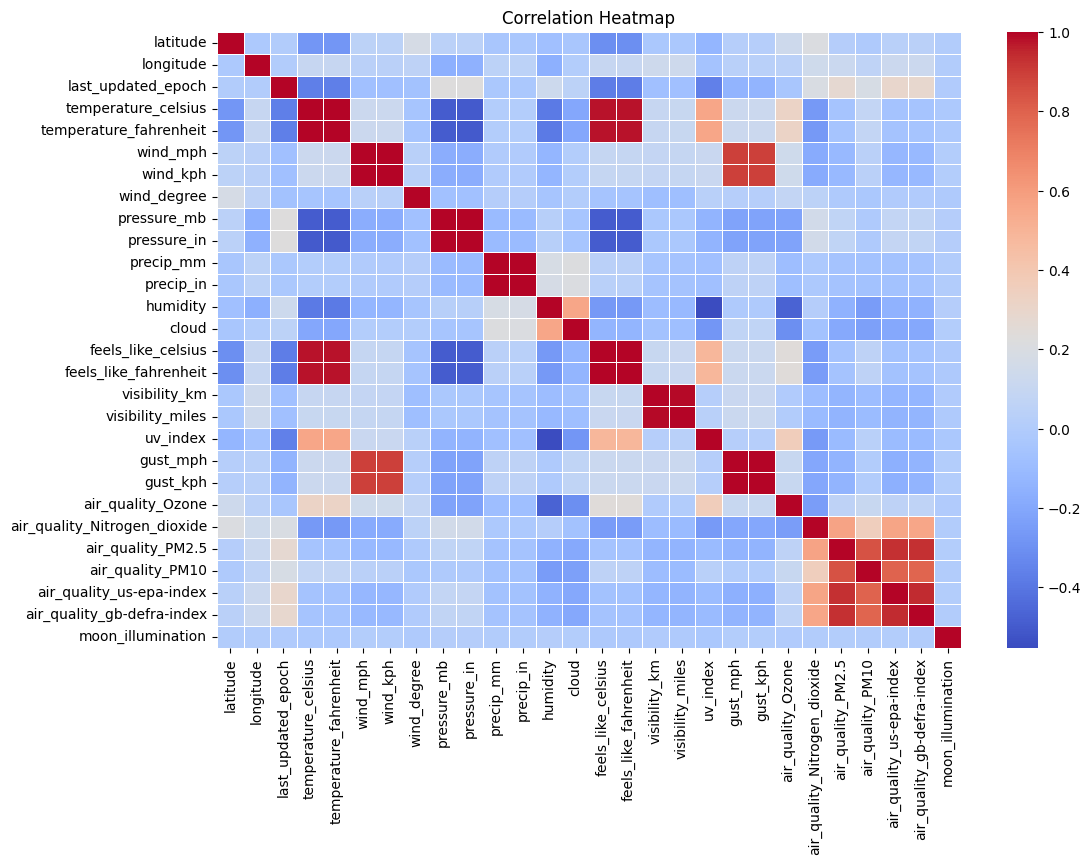

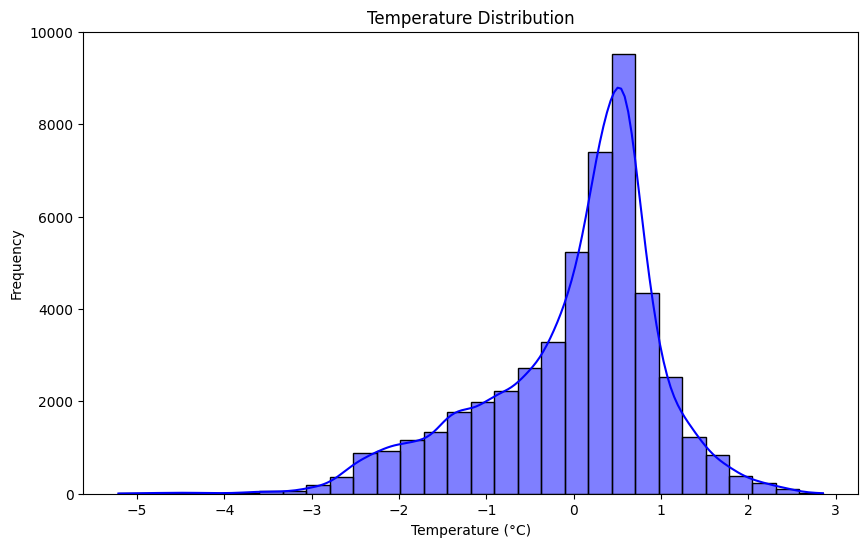

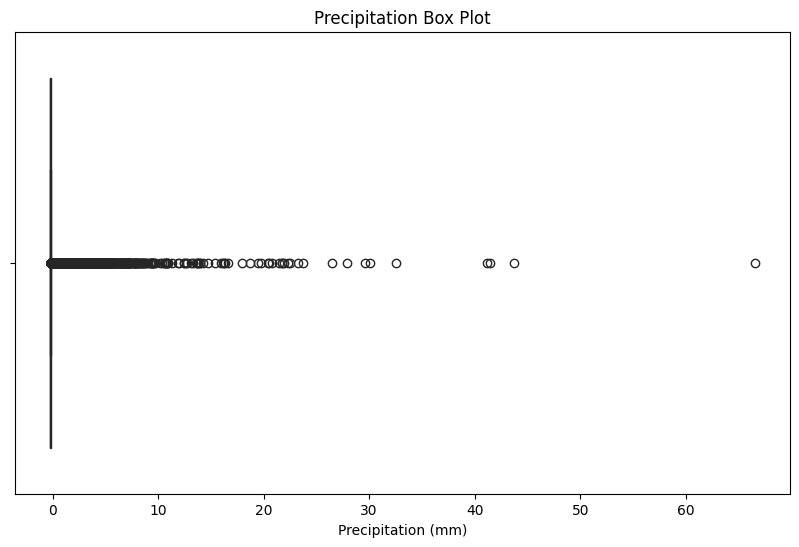

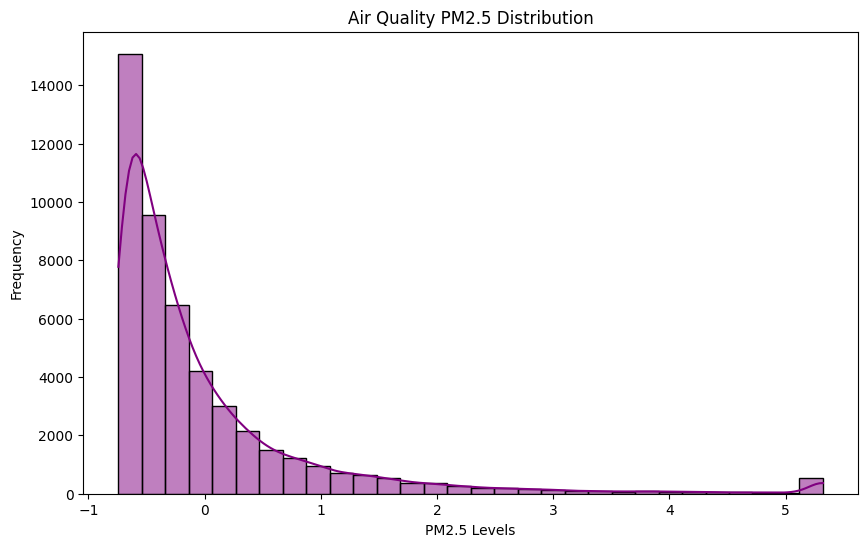

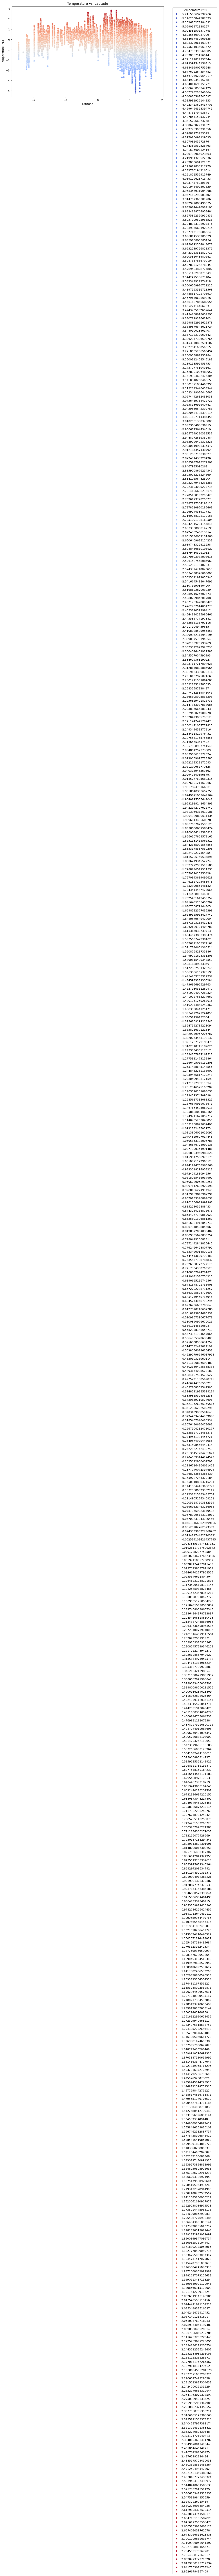

RMSE: 1.2047
MAE: 1.0469


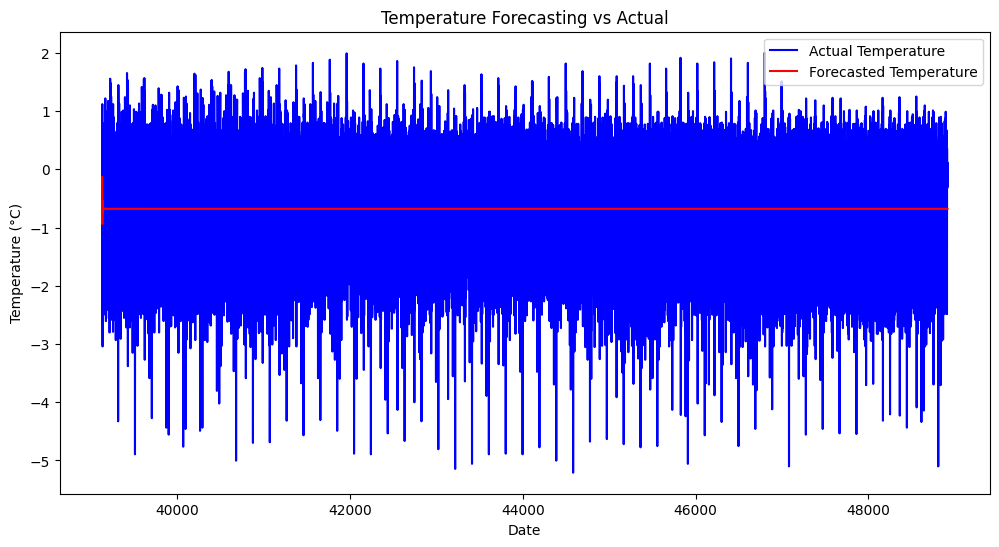

Data cleaning, analysis, forecasting model, and visualizations completed successfully!


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

# Load the dataset
weather_data = pd.read_csv('GlobalWeatherRepository.csv')  # Replace with your file path

# Replace invalid placeholder values (-9999) in air quality columns with NaN
air_quality_columns = [
    "air_quality_Carbon_Monoxide", "air_quality_Ozone",
    "air_quality_Nitrogen_dioxide", "air_quality_Sulphur_dioxide",
    "air_quality_PM2.5", "air_quality_PM10"
]
weather_data[air_quality_columns] = weather_data[air_quality_columns].replace(-9999, pd.NA)

# Cap extreme outliers in wind and air quality metrics at the 99th percentile for each column
outlier_columns = [
    "wind_mph", "wind_kph", "gust_mph", "gust_kph",
    "air_quality_Carbon_Monoxide", "air_quality_PM2.5",
    "air_quality_PM10"
]
percentile_limits = weather_data[outlier_columns].quantile(0.99)
for col in outlier_columns:
    weather_data[col] = weather_data[col].clip(upper=percentile_limits[col])

# Normalize only numerical columns
numerical_columns = weather_data.select_dtypes(include=["float64", "int64"]).columns
weather_data[numerical_columns] = (weather_data[numerical_columns] - weather_data[numerical_columns].mean()) / weather_data[numerical_columns].std()

# Check column names to see if 'lastupdated' exists
print(weather_data.columns)

# If 'lastupdated' is present, proceed with the code; otherwise, check for the correct column name
if 'lastupdated' in weather_data.columns:
    # Convert 'lastupdated' to datetime format
    weather_data['lastupdated'] = pd.to_datetime(weather_data['lastupdated'])

    # Set 'lastupdated' as the index for time series analysis
    weather_data.set_index('lastupdated', inplace=True)
else:
    print("Column 'lastupdated' does not exist. Please check the column name.")

# Handle missing values in the target column (e.g., temperature_celsius) by forward filling
weather_data['temperature_celsius'] = weather_data['temperature_celsius'].fillna(method='ffill')

# Data Analysis and Visualizations

# 1. Correlation Heatmap
plt.figure(figsize=(12, 8))
correlation_matrix = weather_data[numerical_columns].corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, fmt='.2f', linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

# 2. Temperature Trends
if "temperature_celsius" in weather_data.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(weather_data["temperature_celsius"], kde=True, color="blue", bins=30)
    plt.title("Temperature Distribution")
    plt.xlabel("Temperature (°C)")
    plt.ylabel("Frequency")
    plt.show()

# 3. Precipitation Trends
if "precip_mm" in weather_data.columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=weather_data["precip_mm"], color="green")
    plt.title("Precipitation Box Plot")
    plt.xlabel("Precipitation (mm)")
    plt.show()

# 4. Air Quality PM2.5 Analysis
if "air_quality_PM2.5" in weather_data.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(weather_data["air_quality_PM2.5"], kde=True, color="purple", bins=30)
    plt.title("Air Quality PM2.5 Distribution")
    plt.xlabel("PM2.5 Levels")
    plt.ylabel("Frequency")
    plt.show()

# 5. Geographical Analysis: Temperature vs. Latitude
if "latitude" in weather_data.columns and "temperature_celsius" in weather_data.columns:
    plt.figure(figsize=(10, 6))
    scatter = sns.scatterplot(
        x=weather_data["latitude"],
        y=weather_data["temperature_celsius"],
        hue=weather_data["temperature_celsius"],
        palette="coolwarm",
        legend="full"
    )
    plt.title("Temperature vs. Latitude")
    plt.xlabel("Latitude")
    plt.ylabel("Temperature (°C)")
    plt.legend(title="Temperature (°C)", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

# 6. Build a Simple Forecasting Model (ARIMA)
# We will use the temperature data for forecasting

# Splitting data into training and testing sets (80% for training, 20% for testing)
train_size = int(len(weather_data) * 0.8)
train, test = weather_data['temperature_celsius'][:train_size], weather_data['temperature_celsius'][train_size:]

# Fit ARIMA model (you can tune the p, d, q parameters for optimization)
model = ARIMA(train, order=(5, 1, 0))  # Example order, change for better results
model_fit = model.fit()

# Forecasting the test data
forecast = model_fit.forecast(steps=len(test))

# Evaluate the model performance
rmse = sqrt(mean_squared_error(test, forecast))
mae = mean_absolute_error(test, forecast)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

# Plot the actual vs forecasted values
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Actual Temperature', color='blue')
plt.plot(test.index, forecast, label='Forecasted Temperature', color='red')
plt.title("Temperature Forecasting vs Actual")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()

# Save the cleaned data to a new CSV file
weather_data.to_csv("Cleaned_Weather_Data.csv", index=True)

print("Data cleaning, analysis, forecasting model, and visualizations completed successfully!")